In [67]:
import pandas as pd
import geopandas as gpd

from numpy import clip
from torch.autograd import Variable
import torch
from torch import Tensor
from torch.optim import SGD
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact
from scipy import special

import matplotlib
from matplotlib import pyplot as plt
import seaborn.apionly as sns
plt.style.use('clean')

w = widgets.IntText()



%matplotlib inline
%run utils.py

In [2]:
M, N = (20,70) 

In [3]:
def unif_path_weights(source, target):
    sx, sy = source
    tx, ty = target
    x_d, y_d = abs(tx-sx), abs(ty-sy)
    
    x, y = np.meshgrid(range(x_d+1), range(y_d+1))
    
    paths1 = special.binom(x+y,x)
    paths2 = special.binom(x_d+y_d-x-y, x_d-x)
    total_paths = special.binom(x_d+y_d,x_d)
    
    small_grid = (paths1 * paths2 / total_paths).T
    
    if (tx-sx)*(ty-sy) < 0:
        small_grid = small_grid[::-1, :]
    
    full_grid = np.zeros((M,N))
    full_grid[min(sx, tx):max(sx,tx)+1, min(sy, ty):max(sy,ty)+1] = small_grid
    
    return full_grid

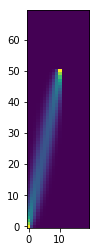

In [4]:
plt.imshow(unif_path_weights((10,50), (0,0)).T, origin='lower')

In [34]:
weights = Variable((15 * torch.ones((M,N))).float(), requires_grad=True)

In [6]:
@interact(x=w)
def plot(x):
    plt.figure(figsize=(10,10))
    plt.imshow(torch.nn.functional.softplus(weights).data.numpy().T, 
               clim=(0,80), cmap='bwr', origin='lower')
    plt.show()
    

interactive(children=(IntText(value=0, description='x'), Output()), _dom_classes=('widget-interact',))

In [7]:
def predict(sx, sy, tx, ty):
    sx, sy, tx, ty = sx//2, sy//2, tx//2, ty//2
    
    source = (int(sx), int(sy))
    target = (int(tx), int(ty))
    path = unif_path_weights(source, target)
    pred = (Variable(Tensor(path)) 
            * torch.nn.functional.softplus(weights)).sum()
    return pred
    
def predict_num(sx, sy, tx, ty):
    return predict(sx, sy, tx, ty).data[0]

In [35]:
optimizer = SGD([weights], lr = 1e-4)
num_epochs = 10

df = pd.read_csv('data/split/JC_week1_hour18_40x140.csv')
losses = []
pbar = tqdm(total=num_epochs*len(df))
for epoch in range(num_epochs):
    for _, duration, sx, sy, tx, ty in df.sample(frac=1).itertuples():
        if pbar.n % 1000 == 0:
            w.value += 1
        pbar.update(1)
        pred = predict(sx, sy, tx, ty)
        loss = (pred - duration) ** 2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])

HBox(children=(IntProgress(value=0, max=852890), HTML(value='')))

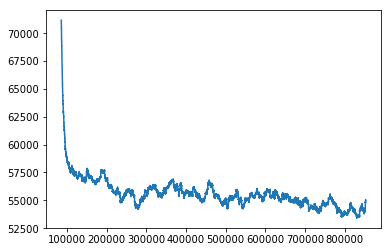

In [36]:
plt.plot(pd.Series(losses).rolling(len(losses)//10).mean())

In [37]:
weights18 = weights.clone()

852890/|/100%|| 852890/852890 [11:01<00:00, 1533.98it/s]

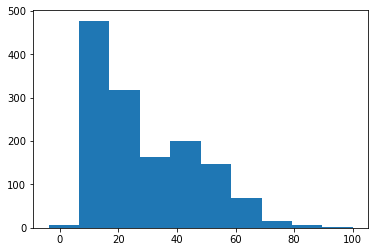

In [10]:
plt.hist((weights.data.numpy()[~np.isnan(weights.data.numpy())]));

In [13]:
%run test.py

In [42]:
np.save('results/unif_weights18.npy', weights18.data.numpy())

In [153]:
mph_constant = 272.727272
upper_lim = 17

/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


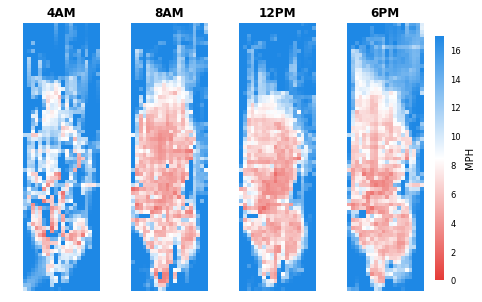

In [154]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('br1', 
    ['#E53935', '#FFFFFF', '#1E88E5'], N=1000)

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('br1', 
#     ['#FFFFFF', '#000000'], N=1000)

#plt.figure(figsize=(5,4))
ax1 = plt.subplot(141)
plt.imshow(mph_constant / torch.nn.functional.softplus(weights4).data.numpy().T, 
           clim=(0,upper_lim), cmap=cmap, origin='lower')
plt.title('4AM')
plt.xticks([])
sns.despine(left=True, bottom=True)

plt.subplot(142, sharey=ax1)
plt.imshow(mph_constant / torch.nn.functional.softplus(weights8).data.numpy().T, 
           clim=(0,upper_lim), cmap=cmap, origin='lower')
plt.title('8AM')
plt.xticks([])
sns.despine(left=True, bottom=True)

plt.subplot(143, sharey=ax1)
plt.imshow(mph_constant / torch.nn.functional.softplus(weights12).data.numpy().T, 
           clim=(0,upper_lim), cmap=cmap, origin='lower')
plt.title('12PM')
plt.xticks([])
sns.despine(left=True, bottom=True)

plt.subplot(144, sharey=ax1)
x = plt.imshow(mph_constant / torch.nn.functional.softplus(weights18).data.numpy().T, 
           clim=(0,upper_lim), cmap=cmap, origin='lower')
plt.title('6PM')
plt.xticks([])
sns.despine(left=True, bottom=True)

plt.yticks([]);

colorb_ax = plt.gcf().add_axes((0.99,0.05,0.02,0.85))
cb = plt.gcf().colorbar(x, cax=colorb_ax)
cb.outline.set_visible(False)

for tick in colorb_ax.get_yticklines():
    tick.set_visible(False)
plt.ylabel('MPH')

plt.tight_layout(False)
plt.savefig('reports/paper/figs/unifmaps.pdf', bbox_inches = 'tight')

numpy.float64

In [100]:
f.add_axes

In [91]:
sf_weights4 = torch.Tensor(np.load('results/weights_week1hour4_f.npy'))
sf_weights8 = torch.Tensor(np.load('results/weights_week1hour8_f.npy'))
sf_weights12 = torch.Tensor(np.load('results/weights_week1hour12_f.npy'))
sf_weights18 = torch.Tensor(np.load('results/weights_week1hour18_f.npy'))

/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


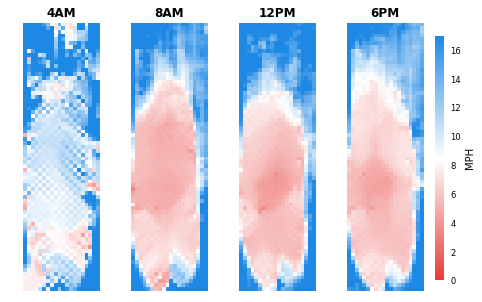

In [155]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('br1', 
    ['#E53935', '#FFFFFF', '#1E88E5'], N=1000)

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('br1', 
#     ['#FFFFFF', '#000000'], N=1000)

#plt.figure(figsize=(5,4))
ax1 = plt.subplot(141)
plt.imshow(mph_constant / torch.nn.functional.softplus(sf_weights4).data.numpy().T, 
           clim=(0,upper_lim), cmap=cmap, origin='lower')
plt.title('4AM')
plt.xticks([])
sns.despine(left=True, bottom=True)

plt.subplot(142, sharey=ax1)
plt.imshow(mph_constant / torch.nn.functional.softplus(sf_weights8).data.numpy().T, 
           clim=(0,upper_lim), cmap=cmap, origin='lower')
plt.title('8AM')
plt.xticks([])
sns.despine(left=True, bottom=True)

plt.subplot(143, sharey=ax1)
plt.imshow(mph_constant / torch.nn.functional.softplus(sf_weights12).data.numpy().T, 
           clim=(0,upper_lim), cmap=cmap, origin='lower')
plt.title('12PM')
plt.xticks([])
sns.despine(left=True, bottom=True)

plt.subplot(144, sharey=ax1)
x = plt.imshow(mph_constant / torch.nn.functional.softplus(sf_weights18).data.numpy().T, 
           clim=(0,upper_lim), cmap=cmap, origin='lower')
plt.title('6PM')
plt.xticks([])
sns.despine(left=True, bottom=True)

plt.yticks([]);

colorb_ax = plt.gcf().add_axes((0.99,0.05,0.02,0.85))
cb = plt.gcf().colorbar(x, cax=colorb_ax)
cb.outline.set_visible(False)

for tick in colorb_ax.get_yticklines():
    tick.set_visible(False)
plt.ylabel('MPH')

plt.tight_layout(False)
plt.savefig('reports/paper/figs/softmaxmaps.pdf', bbox_inches = 'tight')

In [14]:
errs = test(predict_num, 'results/unif_tues8am_Fri2208')

HBox(children=(IntProgress(value=0, max=9697), HTML(value='')))